# Set Up the development environment

## Install the matrice package or upgrade it if already installed

In [ ]:
!pip install --upgrade matrice

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 2.8 MB/s eta 0:00:00


## Install required dependencies

In [ ]:
!pip install pycocotools opendatasets pyyaml boto3 pymongo seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 6.5 MB/s eta 0:00:00


## Setting up the credentials
*   ENV
*   MATRICE_ACCESS_KEY_ID
*   MATRICE_SECRET_ACCESS_KEY
*   MATRICE_ACCOUNT_NUMBER

In [ ]:
import yaml
import os

class Vars:
    _data = {}
    _path = None

    @classmethod
    def initialize(cls, path):
        cls._path = path
        cls._data = cls.load()

    @classmethod
    def load(cls):
        if cls._path and os.path.exists(cls._path):
            with open(cls._path, 'r') as f:
                return yaml.safe_load(f)
        return {}

    @classmethod
    def get(cls, key):
        if key not in cls._data:
            raise KeyError(f"Variable {key} not found")
        return cls._data[key]

    @classmethod
    def set(cls, key, value):
        cls._data[key] = value
        with open(cls._path, 'w') as f:
            yaml.safe_dump(cls._data, f, default_flow_style=False)


In [ ]:
Vars.initialize('vars.yaml')

In [ ]:
Vars.set("ENV", "prod")
Vars.set("MATRICE_ACCESS_KEY_ID", "VB8************O60")
Vars.set("MATRICE_SECRET_ACCESS_KEY", "PR***********5IKJ")
Vars.set("MATRICE_ACCOUNT_NUMBER", "978**************15")

In [ ]:
import os
os.environ['ENV'] = Vars.get('ENV')
access_key = Vars.get('MATRICE_ACCESS_KEY_ID')
secret_key = Vars.get('MATRICE_SECRET_ACCESS_KEY')
account_number = Vars.get('MATRICE_ACCOUNT_NUMBER')

## Import required matrice modules

In [ ]:
from matrice.session import Session
from matrice.projects import Projects
from matrice.dataset import Dataset
from matrice.models import Model
from matrice.deployment import Deployment
from matrice.exported_model import ExportedModel
import sys
import os

# Create Classification Project with Matrice SDK

1.   Initialize matrice connection session
2.   List projects in user account
3.   Create the Project
4.   Update the session with the project_id

In [ ]:
session_instance = Session.create_session(account_number=account_number, access_key=access_key, secret_key=secret_key)
print("A Session has been initialized:", session_instance)

A Session has been initialized: <matrice.session.Session object at 0x7dd6fd97a410>


In [ ]:
import pprint

# Function to create a project
def create_project(project_name, project_type):

    enabled_platforms = {
        "matrice": True,
        "android": False,
        "ios": False,
        "tpu": False,
        "intelCPU": False,
        "gcloudGPU": False
    }

    resp, error = session_instance._create_project(project_name, "image", project_type)
    if error:
        print(f"Error: {error}")
        return None, None
    else:
        print(f"Project created with ID: {resp['_id']}")
        return resp['_id'], resp['name']


In [ ]:
project_id, project_name = create_project(project_name = "Skin Cancer Classification", project_type = 'classification')


print("----------------------------")
print(f"Project ID: {project_id}")
print(f"Project Name: {project_name}")
print("----------------------------")

Project created with ID: 672fa1cf8c7add7d7323445c
----------------------------
Project ID: 672fa1cf8c7add7d7323445c
Project Name: Skin Cancer Classification
----------------------------


In [ ]:
Vars.set("project_name", project_name)
Vars.set("project_id", project_id)

In [ ]:
session_instance.update(Vars.get("project_id"))
project_instance = Projects(session_instance, project_name=Vars.get("project_name"))
print("A Project class has been initialized", project_instance)

A Project class has been initialized <matrice.projects.Projects object at 0x7dd6fd97a560>


# Preparing the Dataset


1.   Dataset Downlaod (either local download or use scripts to download)
2.   Dataset Exploration
3.   Plot Samples from the Dataset
4.   Dataset Format Preparation in ImageNet
5.   Compress the Dataset to be ready for uploading

## Dataset Downlaod

In [ ]:
from opendatasets import download
download("https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: g2savege
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign


100%|██████████| 325M/325M [00:06<00:00, 51.0MB/s]


## Dataset Exploration

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to get dataset info
def get_dataset_info(train_path, test_path):

    benign_count = len(os.listdir(train_path + '/benign'))
    malignant_count = len(os.listdir(train_path + '/malignant'))
    benign_count = benign_count + len(os.listdir(test_path  + '/benign'))
    malignant_count = malignant_count + len(os.listdir(test_path + '/malignant'))
    return benign_count, malignant_count

# Function to display class distribution
def display_class_distribution(benign_count, malignant_count):
    labels = ['Benign', 'Malignant']
    counts = [benign_count, malignant_count]

    plt.bar(labels, counts, color=['blue', 'red'])
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.show()



In [ ]:
benign_count, malignant_count = get_dataset_info('skin-cancer-malignant-vs-benign/train', 'skin-cancer-malignant-vs-benign/test')

# Display dataset info
print(f'Number of Benign Images: {benign_count}')
print(f'Number of Malignant Images: {malignant_count}')

Number of Benign Images: 1800
Number of Malignant Images: 1497


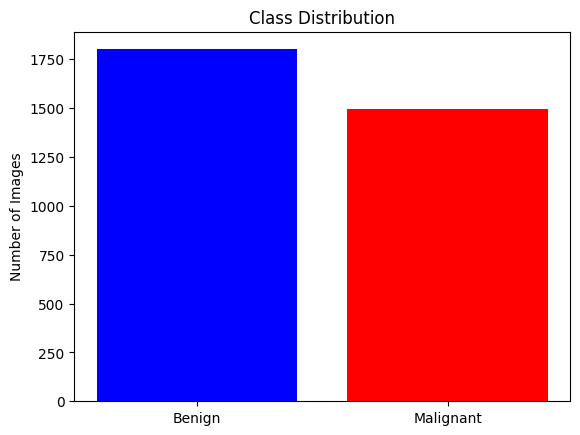

In [ ]:
# Display class distribution
display_class_distribution(benign_count, malignant_count)

## Plot Samples

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image


def plot_samples(num_samples, dataset_dir):
    train_benign = f'{dataset_dir}/benign'
    train_malignant = f'{dataset_dir}/malignant'
    # Get sample images
    benign_samples = random.sample(os.listdir(train_benign), num_samples)
    malignant_samples = random.sample(os.listdir(train_malignant), num_samples)

    # Create a figure for plotting
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    # Plot benign samples
    for ax, sample in zip(axes[0], benign_samples):
        img_path = os.path.join(train_benign, sample)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title('Benign')
        ax.axis('off')  # Turn off axis

    # Plot malignant samples
    for ax, sample in zip(axes[1], malignant_samples):
        img_path = os.path.join(train_malignant, sample)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title('Malignant')
        ax.axis('off')  # Turn off axis

    # Adjust layout
    plt.tight_layout()
    plt.show()


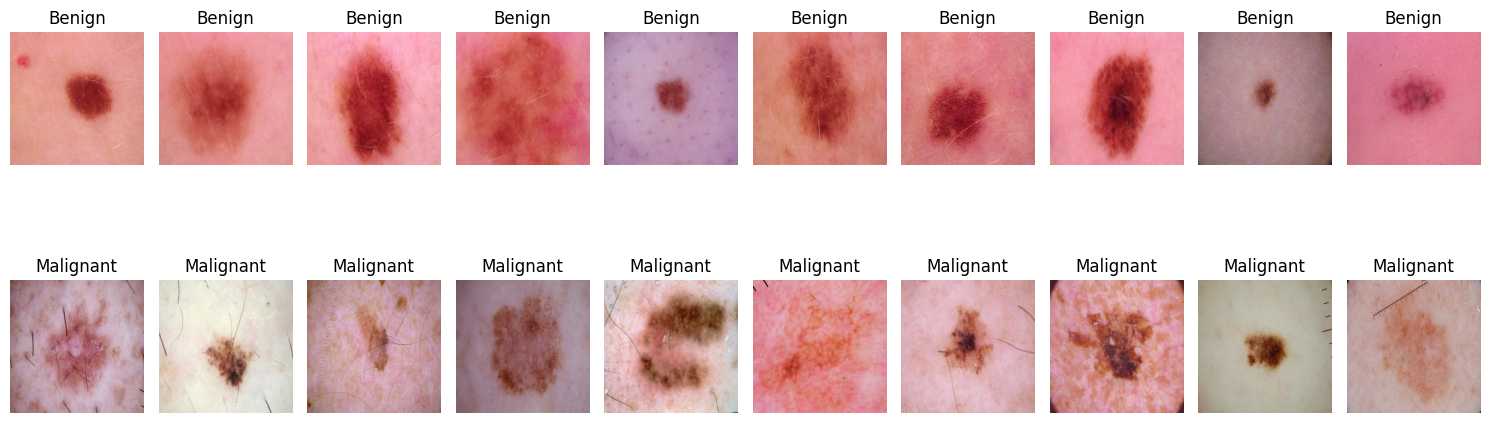

In [ ]:
plot_samples(10, "skin-cancer-malignant-vs-benign/train")

## Dataset Format Preparation in ImageNet

In [ ]:
!rm -rf skin-cancer-malignant-vs-benign/data

combine dataset items

In [ ]:
import os
import shutil
import random

# Define paths
train_benign = 'skin-cancer-malignant-vs-benign/train/benign'
train_malignant = 'skin-cancer-malignant-vs-benign/train/malignant'
test_benign = 'skin-cancer-malignant-vs-benign/test/benign'
test_malignant = 'skin-cancer-malignant-vs-benign/test/malignant'

val_benign = 'skin-cancer-malignant-vs-benign/val/benign'
val_malignant = 'skin-cancer-malignant-vs-benign/val/malignant'

combined_benign = 'skin-cancer-malignant-vs-benign/combined/benign'
combined_malignant = 'skin-cancer-malignant-vs-benign/combined/malignant'

# Create combined directories if they don't exist
os.makedirs(combined_benign, exist_ok=True)
os.makedirs(combined_malignant, exist_ok=True)
os.makedirs(val_benign, exist_ok=True)
os.makedirs(val_malignant, exist_ok=True)

# Function to move files
def move_files(src, dest):
    for file_name in os.listdir(src):
        full_file_name = os.path.join(src, file_name)
        if os.path.isfile(full_file_name):
            shutil.move(full_file_name, dest)

# Move benign and malignant files
move_files(train_benign, combined_benign)
move_files(test_benign, combined_benign)
move_files(train_malignant, combined_malignant)
move_files(test_malignant, combined_malignant)

print("Files have been combined successfully.")

Files have been combined successfully.


In [ ]:
def move_specific_files(src_path, dist_path, file_names):
    # Move files to validation set
    for file_name in file_names:
        shutil.move(os.path.join(src_path, file_name), dist_path)

def slice_list_by_percentage(lst, percentages):

  list_len = len(lst)
  slices = []
  start_index = 0

  for percentage in percentages:
    num_elements = int(list_len * (percentage))
    end_index = start_index + num_elements
    slices.append(lst[start_index:end_index])
    start_index = end_index

  # Handle any remaining elements (due to rounding)
  if start_index < list_len:
    slices[0].extend(lst[start_index:])

  return slices

# Function to split dataset into train, test, and validation
def split_dataset(base_dir, val_size=0.1, test_size = 0.1):
    # Process benign images
    benign_files = os.listdir(base_dir + '/benign')
    random.shuffle(benign_files)

    # Process malignant images
    malignant_files = os.listdir(base_dir + '/malignant')
    random.shuffle(malignant_files)

    train_benign, val_benign, test_benign = slice_list_by_percentage(benign_files, [1-(val_size+test_size), val_size, test_size])
    train_malignant, val_malignant, test_malignant = slice_list_by_percentage(malignant_files, [1-(val_size+test_size), val_size, test_size])

    move_specific_files(base_dir + '/benign', 'skin-cancer-malignant-vs-benign/train/benign', train_benign)
    move_specific_files(base_dir + '/malignant', 'skin-cancer-malignant-vs-benign/train/malignant', train_malignant)
    move_specific_files(base_dir + '/benign', 'skin-cancer-malignant-vs-benign/val/benign', val_benign)
    move_specific_files(base_dir + '/malignant', 'skin-cancer-malignant-vs-benign/val/malignant', val_malignant)
    move_specific_files(base_dir + '/benign', 'skin-cancer-malignant-vs-benign/test/benign', test_benign)
    move_specific_files(base_dir + '/malignant', 'skin-cancer-malignant-vs-benign/test/malignant', test_malignant)


In [ ]:
# Perform the split
split_dataset("skin-cancer-malignant-vs-benign/combined", val_size=0.1, test_size=0.1)

print("Dataset split completed successfully.")

Dataset split completed successfully.


In [ ]:
# The script creates the following directory structure:

# skin-cancer-malignant-vs-benign/
# ├── train/
# │   ├── malignant/
# │   └── benign/
# ├── val/
# │   ├── malignant/
# │   └── benign/
# └── test/
#     ├── malignant/
#     └── benign/

In [ ]:
!rm -rf skin-cancer-malignant-vs-benign/combined

## Compress the Dataset to be ready for uploading

In [ ]:
import zipfile
import os

def zip_directory(directory_path, output_zip_path):
    """
    Zips the given directory and saves it as a zip file with the directory itself included.

    Args:
        directory_path (str): Path to the directory to zip.
        output_zip_path (str): Path where the zip file will be saved (without .zip extension).
    """
    if not os.path.isdir(directory_path):
        print(f"Error: The directory '{directory_path}' does not exist.")
        return

    # Ensure the output path does not include the .zip extension
    if output_zip_path.endswith('.zip'):
        output_zip_path = output_zip_path[:-4]

    try:
        # Create a zip file
        with zipfile.ZipFile(f'{output_zip_path}.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Walk the directory tree
            for root, dirs, files in os.walk(directory_path):
                for file in files:
                    # Create the path to the file relative to the directory being zipped
                    file_path = os.path.join(root, file)
                    # Create the archive path for the file
                    arcname = os.path.relpath(file_path, start=directory_path)
                    # Write the file to the zip archive
                    zipf.write(file_path, arcname=os.path.join(directory_path, arcname))

        print(f"Directory '{directory_path}' has been zipped to '{output_zip_path}.zip'.")
    except Exception as e:
        print(f"An error occurred while zipping the directory: {e}")



In [ ]:
# Variables
directory_path = 'skin-cancer-malignant-vs-benign'  # Path to the directory you want to zip
output_zip_path = 'skin_cancer_malignant_vs_benign'  # Desired output zip file name (without .zip extension)

# Zip the directory
zip_directory(directory_path, output_zip_path)

Directory 'skin-cancer-malignant-vs-benign' has been zipped to 'skin_cancer_malignant_vs_benign.zip'.


# Import the Dataset to the project


1.   Upload the dataset
2.   Start a data import action
3.   Check the status of the dataset import action
4.   Check the processed dataset information

Upload the dataset

For uploading the dataset you have 2 options:-


*   Upload the dataset to cloud storage bucket with `project.upload_cloud_dataset()`
*   Upload the dataset from your local storage with `project.upload_local_dataset() `

In [ ]:
dataset, dataset_action = project_instance.import_local_dataset(
    dataset_name='Skin Cancer Classification',
    file_path = r"skin_cancer_malignant_vs_benign.zip",
    dataset_type = "classification",
    dataset_description = "Skin Cancer Classification",
    version_description = "1st version",
    input_type = "image"
)


In [ ]:
dataset_id = dataset.dataset_id
action_id = dataset_action.action_id

print(f"Dataset ID: {dataset_id}")
print(f"Action ID: {action_id}")

Dataset ID: 672fa200d7ca08f1f0da610d
Action ID: 672fa2008c7add7d7323445d


In [ ]:
Vars.set("dataset_id", dataset.dataset_id)
Vars.set("dataset_action_id", dataset_action.action_id)

In [ ]:
import time
import pprint

def check_dataset_status(session_instance):
    while True:
        print(" ")
        print("-------Status------")
        D = Dataset(session_instance, dataset_id=dataset_id)
        status = D.version_status
        print("Status of dataset:", status)
        print("-------------------")
        if status == 'processed':
            print("---------Preprocesing Complete---------")
            print("Dataset processed, proceed with experiment creation.")
            print("---------------------------------------")
            break

        time.sleep(180)  # Wait for 180 seconds before checking again


In [ ]:
# Run the function to check dataset status
check_dataset_status(session_instance)

 
-------Status------
Status of dataset: queued
-------------------
 
-------Status------
Status of dataset: queued
-------------------
 
-------Status------
Status of dataset: processing
-------------------
 
-------Status------
Status of dataset: processed
-------------------
---------Preprocesing Complete---------
Dataset processed, proceed with experiment creation.
---------------------------------------


In [ ]:
def print_dataset_info(dataset):

    dataset_id = dataset.dataset_details['_id']
    dataset_name = dataset.dataset_details['name']
    version_status = dataset.dataset_details.get("stats", [{}])[0].get("versionStatus")
    latest_version = dataset.dataset_details['latestVersion']
    no_of_samples = sum(version['versionStats']['total'] for version in dataset.dataset_details.get('stats', []))
    no_of_classes = len(dataset.dataset_details.get('stats', [{}])[0].get('classStat', {}))
    no_of_versions = len(dataset.dataset_details.get('allVersions', []))
    last_updated_at = dataset.dataset_details.get('updatedAt')

    print(f"Dataset ID: {dataset_id}")
    print(f"Dataset Name: {dataset_name}")
    print(f"Version Status: {version_status}")
    print(f"Latest Version: {latest_version}")
    print(f"Number of Samples: {no_of_samples}")
    print(f"Number of Classes: {no_of_classes}")
    print(f"Number of Versions: {no_of_versions}")
    print(f"Last Updated At: {last_updated_at}")


In [ ]:
dataset.refresh()
print_dataset_info(dataset)

Dataset ID: 672fa200d7ca08f1f0da610d
Dataset Name: Skin Cancer Classification
Version Status: processed
Latest Version: v1.0
Number of Samples: 3297
Number of Classes: 2
Number of Versions: 1
Last Updated At: 2024-11-09T18:04:09.007Z


In [ ]:
import pprint
dataset_summary = dataset.summary
pprint.pprint(dataset_summary)

{'categoryCount': 2,
 'dataItemCount': 3297,
 'histogram': [{'_id': '672fa3bb77f3f38937afa733',
                'count': 1497,
                'label': 'malignant',
                'test': 149,
                'train': 1199,
                'unassigned': 0,
                'val': 149},
               {'_id': '672fa3bb77f3f38937afa734',
                'count': 1800,
                'label': 'benign',
                'test': 180,
                'train': 1440,
                'unassigned': 0,
                'val': 180}],
 'testDataItemCount': 329,
 'trainDataItemCount': 2639,
 'unassignedDataItemCount': 0,
 'valDataItemCount': 329}


In [ ]:
import plotly.graph_objects as go
import pandas as pd
import plotly.io as pio


# Convert the histogram data to a DataFrame
df = pd.DataFrame(dataset_summary['histogram'])

# Bar chart for counts by category
fig1 = go.Figure(data=[go.Bar(x=df['label'], y=df['count'])])
fig1.update_layout(
    title='Count of Items by Category',
    xaxis_title='Category',
    yaxis_title='Count'
)

# Pie chart for distribution of data items
fig2 = go.Figure(data=[go.Pie(
    labels=['Test', 'Train', 'Unassigned', 'Validation'],
    values=[dataset_summary['testDataItemCount'], dataset_summary['trainDataItemCount'], dataset_summary['unassignedDataItemCount'], dataset_summary['valDataItemCount']],
    hole=0.3
)])
fig2.update_layout(
    title='Distribution of Data Items'
)

# Display the figures
fig1.show()
fig2.show()


# Create a Model Training experiment

1.   Create a Model Training experiment
2.   Explore the available SOTA model families and models
3.   Get the default training config , modify it if needed.
4.   Add the model for training.
5.   Start the model train action and Check for the status

## Create a Model Training experiment

In [ ]:
# Create a new experiment
experiment_instance = project_instance.create_experiment(
    name = "Skin-Cancer-Classification-Experiment-1",
    dataset_id = dataset_id,
    dataset_version = "v1.0",
    target_run_time = "PyTorch",
    primary_metric = "acc@1",
    matrice_compute = True
)

[{'_id': '672fa200d7ca08f1f0da610d', 'name': 'Skin Cancer Classification', '_idProject': '672fa1cf8c7add7d7323445c', 'status': '', 'createdAt': '2024-11-09T17:55:12.683Z', 'updatedAt': '2024-11-09T18:04:09.007Z', 'stats': [{'version': 'v1.0', 'versionStats': {'test': 329, 'train': 2639, 'val': 329, 'unassigned': 0, 'total': 3297}, 'versionDescription': '1st version', 'classStat': {'benign': {'total': 1800, 'train': 1440, 'test': 180, 'val': 180, 'unassigned': 0}, 'malignant': {'total': 1497, 'train': 1199, 'test': 149, 'val': 149, 'unassigned': 0}}, 'versionStatus': 'processed', 'isFrozen': False, 'splitwiseBalance': True, 'classwiseBalance': False}], 'allVersions': ['v1.0'], 'processedVersions': ['v1.0'], 'latestVersion': 'v1.0', 'disabledVersions': None}]


In [ ]:
experiment_id = experiment_instance.experiment_id
experiment_name = experiment_instance.experiment_name

print("----------------------------")
print(f"Experiment ID: {experiment_id}")
print(f"Experiment Name: {experiment_name}")
print(f"Experiment instance has been created: {experiment_instance}")
print("----------------------------")

----------------------------
Experiment ID: 672fa423eabd982c294b3d25
Experiment Name: Skin-Cancer-Classification-Experiment-1
Experiment instance has been created: <matrice.experiment.Experiment object at 0x7dd6bd390640>
----------------------------


In [ ]:
Vars.set("experiment_id", experiment_instance.experiment_id)
Vars.set("experiment_name", experiment_instance.experiment_name)

## Explore the available SOTA model families and modelsn

In [ ]:
from matrice.model_store import _get_all_model_families

resp , error , mesage = _get_all_model_families(session_instance, project_id, project_type="classification")
print("----List of available Detection models on platform----")
# Iterate through each model family in the response
for model_family in resp:
    # Extract _id and modelFamily (model family name)
    model_family_id = model_family.get('_id')
    name = model_family.get('modelFamily')
    # Print in formatted manner
    print(f"ID: {model_family_id}, Model Family Name: {name}")

----List of available Detection models on platform----
ID: 65c6771c5f34a0e8878e3e8c, Model Family Name: DenseNet
ID: 65c677205f34a0e8878e3ea5, Model Family Name: MobileNet
ID: 65c677245f34a0e8878e3eb8, Model Family Name: WideResNet
ID: 65c677275f34a0e8878e3ec5, Model Family Name: GoogleNet
ID: 65c6772a5f34a0e8878e3ecc, Model Family Name: Inception V3
ID: 65c6772c5f34a0e8878e3ed3, Model Family Name: ResNet
ID: 65c677315f34a0e8878e3ef2, Model Family Name: EfficientNet V2
ID: 65c677395f34a0e8878e3f24, Model Family Name: EfficientNet
ID: 65c6773f5f34a0e8878e3f55, Model Family Name: SqueezeNet
ID: 65c677425f34a0e8878e3f62, Model Family Name: ViT
ID: 65c677475f34a0e8878e3f81, Model Family Name: ShuffleNet
ID: 65c677505f34a0e8878e3fb9, Model Family Name: AlexNet
ID: 65c677535f34a0e8878e3fc0, Model Family Name: VGG


In [ ]:
from matrice.model_store import ModelFamily

model_family_id = "65c677315f34a0e8878e3ef2"
# Initialize the ModelFamily instance after choosing a Model Family
model_family_instance = ModelFamily(session_instance, model_family_id=model_family_id) # Update with the model family ID of your choice
print("A ModelFamily instance has been initialized", model_family_instance)

A ModelFamily instance has been initialized <matrice.model_store.ModelFamily object at 0x7dd6bd0813c0>


In [ ]:
model_family_instance.family_data['models']

[{'modelName': 'EfficientNetV2 Large', 'modelKey': 'efficientnet_v2_l'},
 {'modelName': 'EfficientNetV2 Medium', 'modelKey': 'efficientnet_v2_m'},
 {'modelName': 'EfficientNetV2 Small', 'modelKey': 'efficientnet_v2_s'}]

## Get the default training config , modify it if needed.

In [ ]:
from matrice.model_store import ModelArch

model_key = "efficientnet_v2_s"  # Update with the model key of your choice
model_family_name = model_family_instance.model_family_name
model_arch_instance = ModelArch(session_instance, model_family_name, model_key)

print(
    "Model Architecture instance initialized for chosen training architecture :",
    model_key,
)

Model Architecture instance initialized for chosen training architecture : efficientnet_v2_s


In [ ]:
import pprint
train_instance, train_config = model_arch_instance.get_train_config(experiment_id=Vars.get('experiment_id'))
print("-----Default Train Config------")
pprint.pprint(train_config)
print("--------------------------------")
print("-------Training instance initialized--------")
print(train_instance)

-----Default Train Config------
{'action_config': {'batch_size': {'allowedValues': [1, 2, 4, 8, 16, 32, 64],
                                  'anyValue': True,
                                  'defaultValue': 4,
                                  'hyperparameter': True,
                                  'keyName': 'batch_size',
                                  'maxValue': 1024,
                                  'minValue': 1,
                                  'selectedValues': [4],
                                  'valueType': 'int32'},
                   'epochs': {'allowedValues': [10,
                                                20,
                                                30,
                                                40,
                                                50,
                                                60,
                                                70,
                                                80,
                                      

In [ ]:
train_config["action_config"] = {}

## Add the model for training.

In [ ]:
train_resp , msg , err = experiment_instance.add_models_for_training(train_instance, train_config)
print("------------Model added for training----------")
pprint.pprint(train_resp)

------------Model added for training----------
[{'_id': '672fa427eabd982c294b3d26',
  '_idActionStatus': '672fa4278c7add7d7323446d',
  '_idDataset': '672fa200d7ca08f1f0da610d',
  '_idExperiment': '672fa423eabd982c294b3d25',
  '_idModelFamily': '000000000000000000000000',
  '_idModelInfo': '65c677325f34a0e8878e3ef4',
  '_idProject': '672fa1cf8c7add7d7323445c',
  '_idUser': '66acf30588ad8dab50c96004',
  'actionConfig': {},
  'autoML': False,
  'bestEpoch': -1,
  'checkpointType': 'predefined',
  'cloudPath': '',
  'createdAt': '2024-11-09T18:04:23.049860869Z',
  'datasetName': 'Skin Cancer Classification',
  'datasetVersion': 'v1.0',
  'indexToCat': {},
  'modelCheckpoint': 'auto',
  'modelConfig': {'_idDataset': '672fa200d7ca08f1f0da610d',
                  'batch_size': 4,
                  'dataset_version': 'v1.0',
                  'docker': '285699223019.dkr.ecr.us-west-2.amazonaws.com/pytorch-vision-imagenet:prod',
                  'epochs': 50,
                  'learning_rate':

## Start the model train action and Check for the status

In [ ]:
import time
from matrice.action import Action

# Define the action ID and the status you want to check
action_id = train_resp[0]['_idActionStatus']
success_status = 'SUCCESS'

# Function to check the status of the action
def check_action_status(S, action_id):
    action_instance = Action(S, action_id)
    print("---------------------")
    print(f"Current Status: {action_instance.status}")
    print(f"Step Code: {action_instance.step_code}")
    print("---------------------")
    return action_instance.status

# Loop to check status every 2 minutes until it is 'success'
while True:
    status = check_action_status(session_instance, action_id)
    if status == success_status:
        print("Action status is 'success'. Model is successfully trained.")
        break
    else:
        print("Model is training. Waiting 10 minutes before checking again.")
        time.sleep(600)


---------------------
Current Status: ACK
Step Code: SCLS_QUE_PROC
---------------------
Model is training. Waiting 10 minutes before checking again.
---------------------
Current Status: OK
Step Code: JBSS_LCK
---------------------
Model is training. Waiting 10 minutes before checking again.
---------------------
Current Status: OK
Step Code: MDL_TRN_STRT
---------------------
Model is training. Waiting 10 minutes before checking again.
---------------------
Current Status: OK
Step Code: MDL_TRN_STRT
---------------------
Model is training. Waiting 10 minutes before checking again.
---------------------
Current Status: OK
Step Code: MDL_TRN_STRT
---------------------
Model is training. Waiting 10 minutes before checking again.
---------------------
Current Status: SUCCESS
Step Code: MDL_TRN_SUCCESS
---------------------
Action status is 'success'. Model is successfully trained.


# Check the performance of the Trained Model

*   Check the performance values
*   Plot the epochs details of the model
*   Get the evaluation results of the model
*   Downlaod the trained model

In [ ]:
model_train_name = train_resp[0]['modelTrainName']
model_id = train_resp[0]['_id']
print(f"Model ID from response data: {model_id}")


# Initialize the Model class with the model_id
model_instance = Model(session_instance, model_name=model_train_name)
print("A Model instance has been initialized : ", model_instance)

Model ID from response data: 672fa427eabd982c294b3d26
A Model instance has been initialized :  <matrice.models.Model object at 0x7dd6bd082980>


In [ ]:
# Print the test score, validation score, and best epoch
print(f"Test Score: {model_instance.test_score}")
print(f"Validation Score: {model_instance.val_score}")
print(f"Best Epoch: {model_instance.best_epoch}")

Test Score: 0.8419452905654907
Validation Score: 0.8389058113098145
Best Epoch: -1


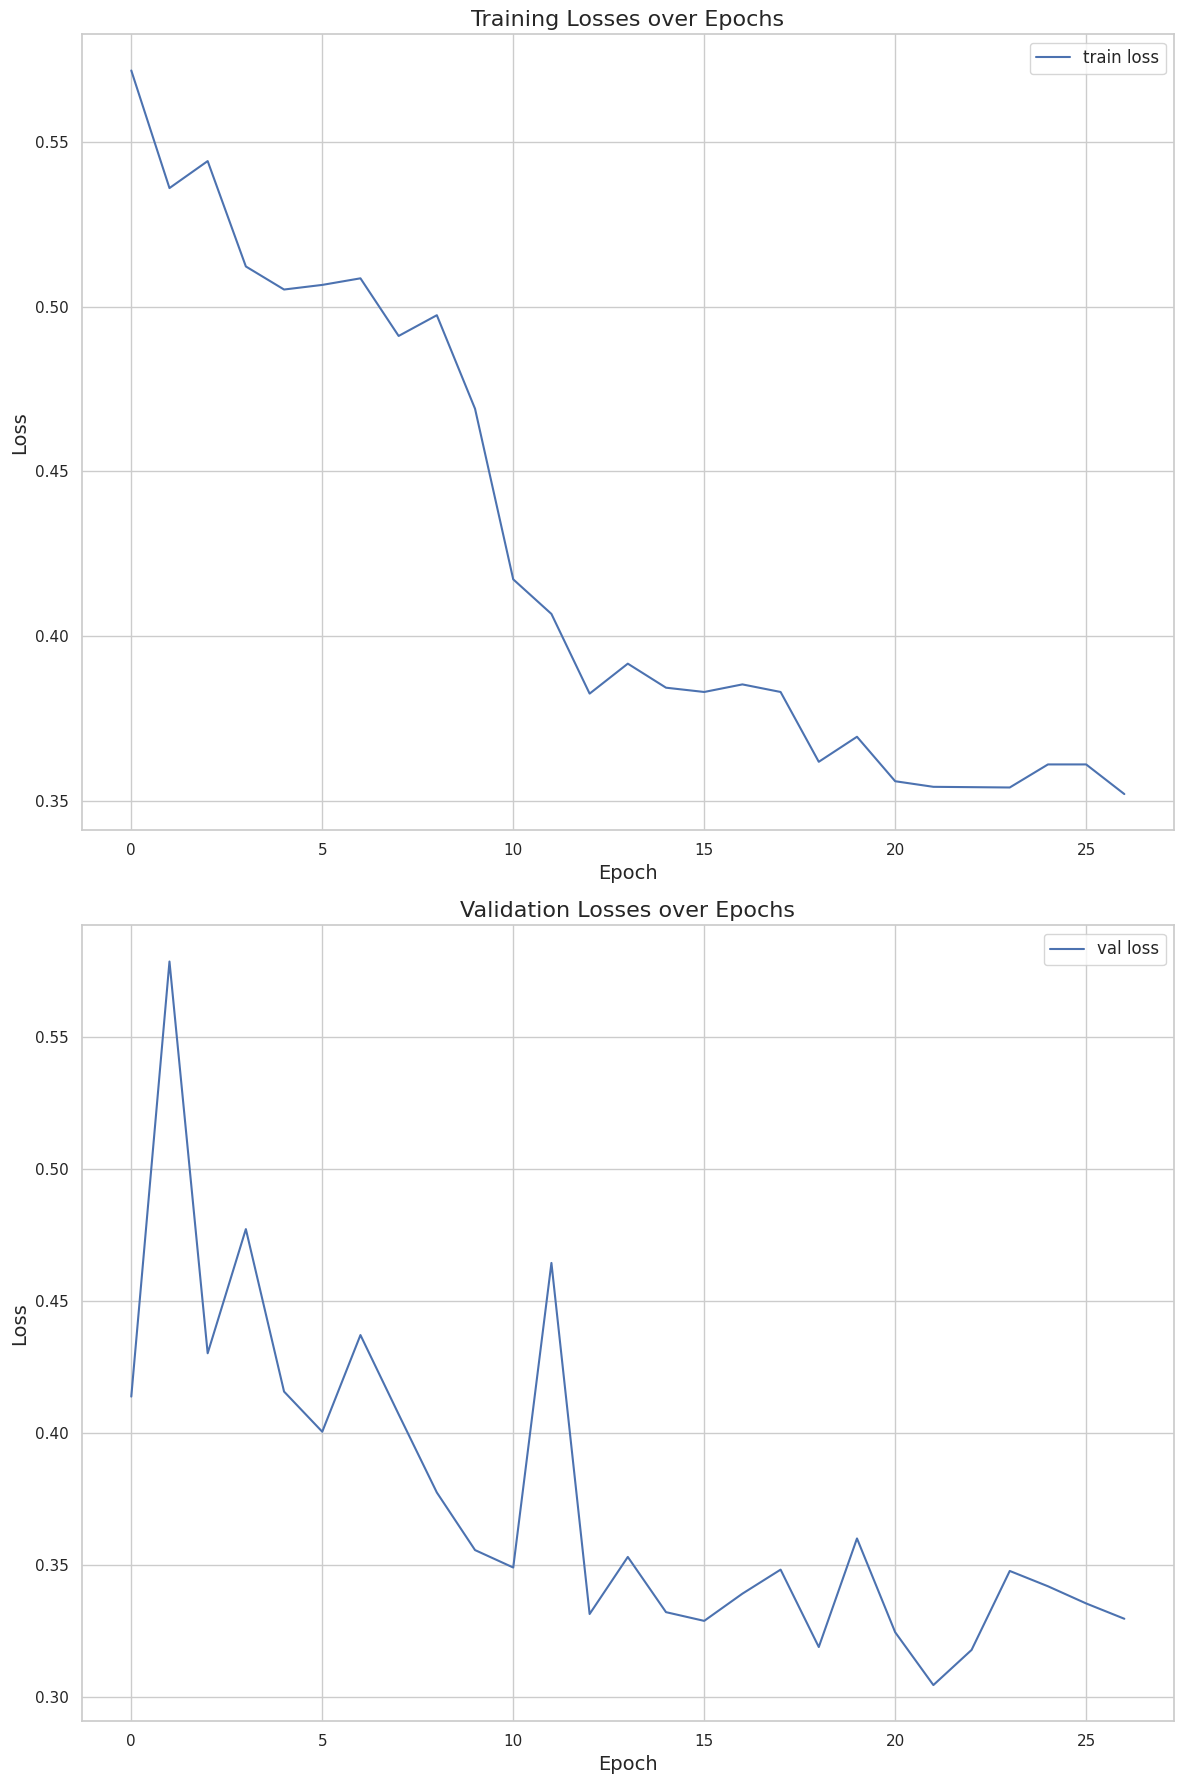

In [ ]:
model_instance.plot_epochs_losses()

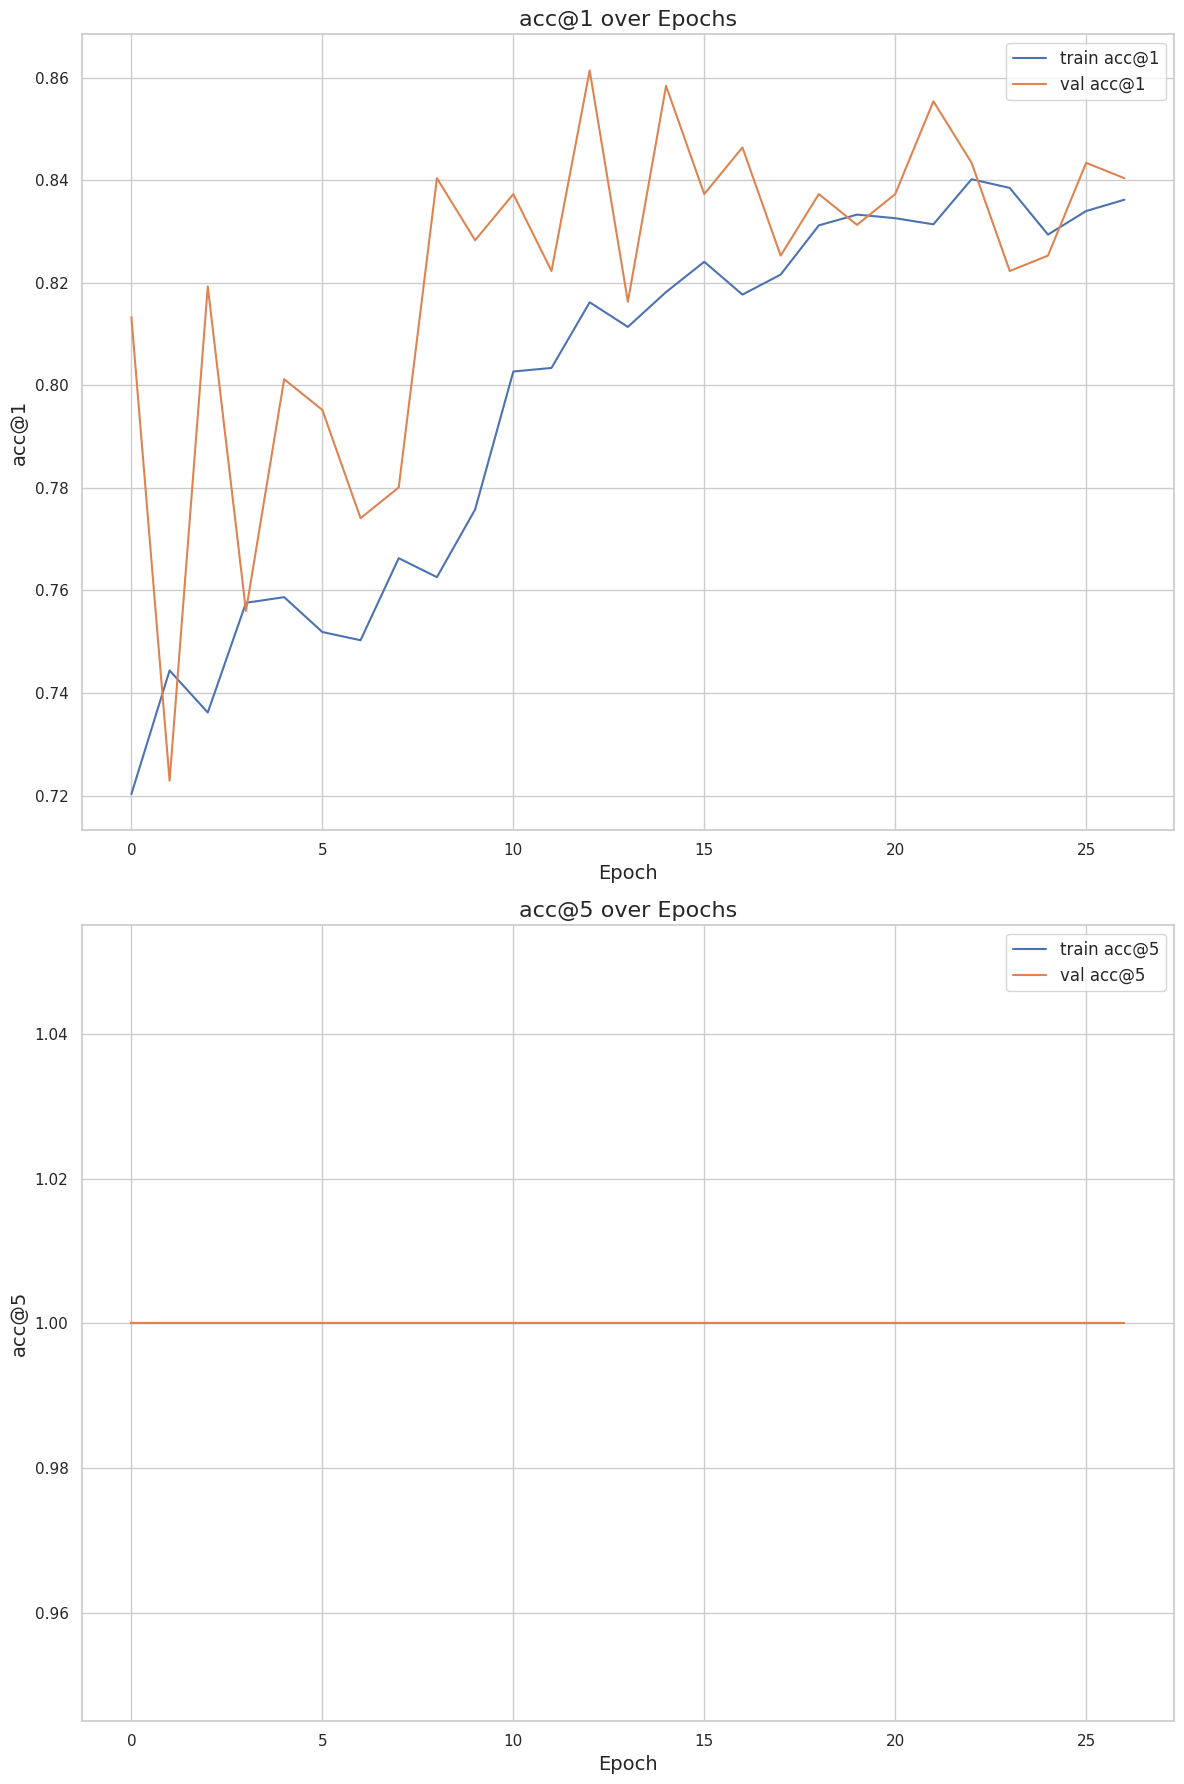

In [ ]:
model_instance.plot_epochs_metrics()

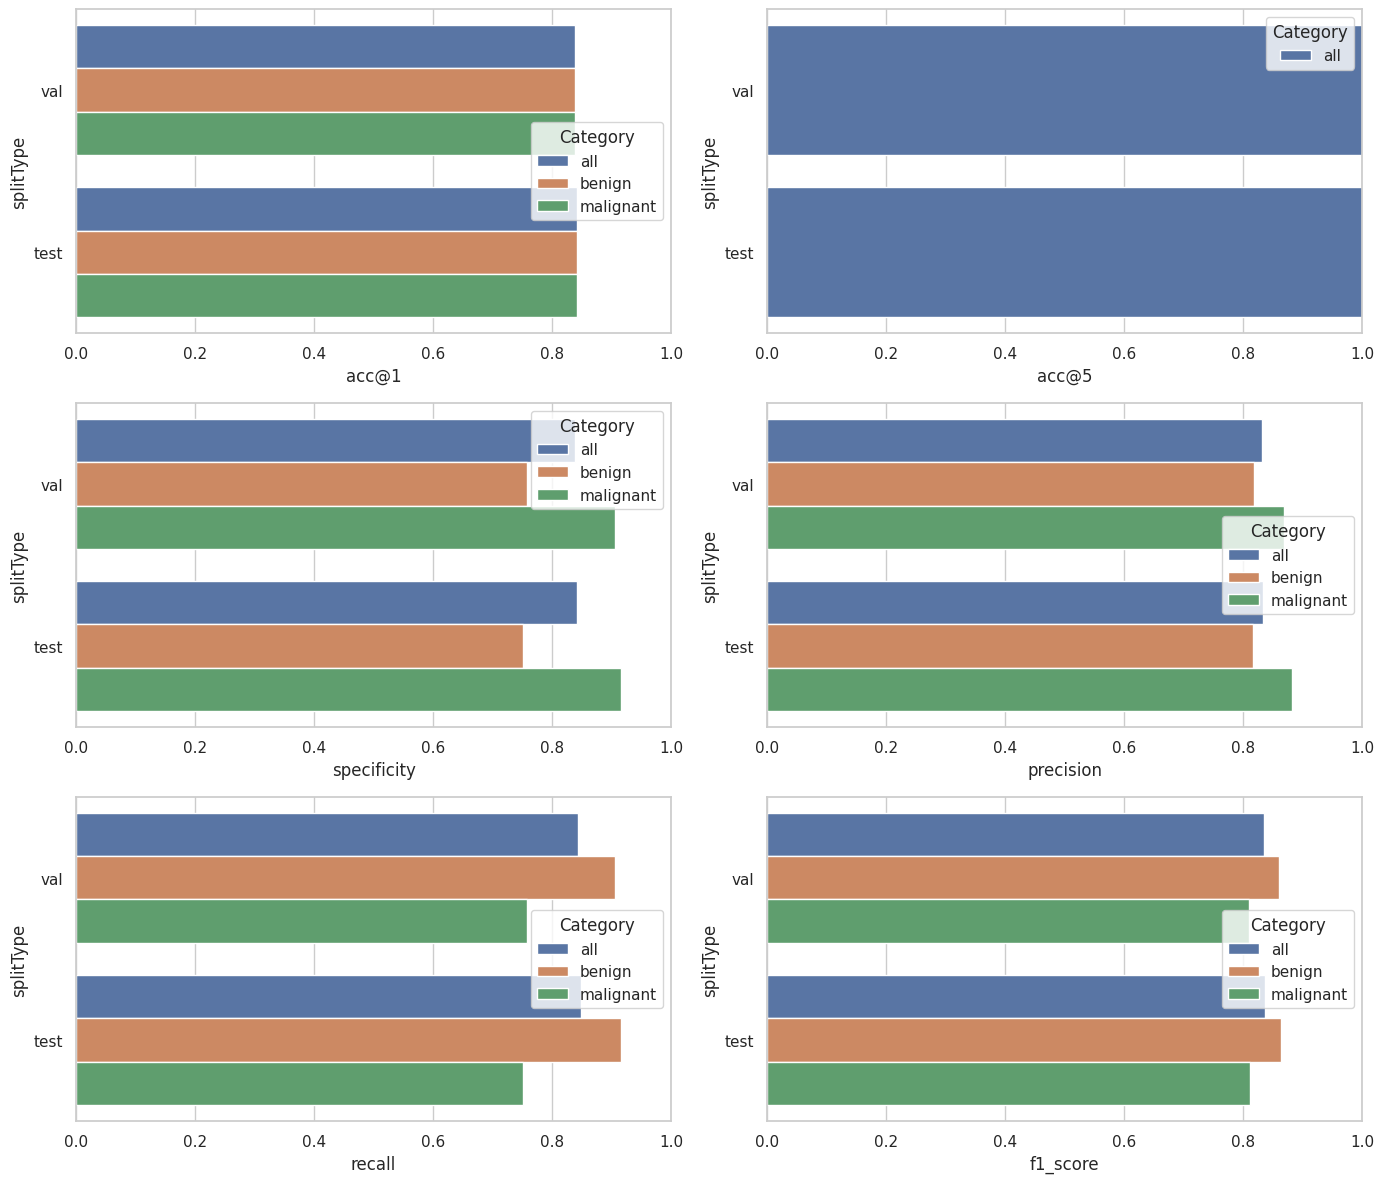

In [ ]:
model_instance.plot_eval_results()

# Export the model based on usage and platform and optimzie the Model Export


1.   Create a model export action using the export config
2.   Check the status of the model export action
3.   Download the exported model

In [ ]:
export_config = train_instance.get_default_export_config("ONNX") # Get the default export config for export format user wants (here ONNX)
print("Export Config for ONNX:")
pprint.pprint(export_config)

Export Config for ONNX:
{'dynamic': False, 'simplify': False}


In [ ]:
exported_instance , action_instance = project_instance.create_model_export(model_id, "ONNX", export_config)

print("Model Export class has been initialized :", exported_instance)
print("----------------------------")
print(f"Export ID: {exported_instance.model_export_id}")
print(f"Export Name: {exported_instance.model_export_name}")
print(f"Action ID: {action_instance.action_id}")
print(f"Action Status: {action_instance.status}")
print("----------------------------")

Model Export class has been initialized : <matrice.exported_model.ExportedModel object at 0x7dd6c6dbac50>
----------------------------
Export ID: 672fafeaeabd982c294b3d28
Export Name: 
Action ID: 672fafea8c7add7d7323448e
Action Status: ACK
----------------------------


In [ ]:
Vars.set("model_export_id", exported_instance.model_export_id)
Vars.set("model_export_name", exported_instance.model_export_name)

In [ ]:
import time
from matrice.action import Action

# Define the action ID and the status you want to check
action_id = action_instance.action_id
success_status = 'SUCCESS'

# Function to check the status of the action
def check_action_status(S, action_id):
    A = Action(S, action_id)
    print("---------------------")
    print(f"Action ID: {action_id}")
    print(f"Current Status: {A.status}")
    print(f"Step Code: {A.step_code}")
    print(f"Action service is : {A.service_name}")
    print("---------------------")
    return A.status

# Loop to check status every 1.5 minutes until it is 'success'
while True:
    status = check_action_status(session_instance, action_id)
    if status == success_status:
        print("Action status is 'success'. Model is successfully exported.")
        break
    else:
        print("Model is exporting. Waiting 2 minutes before checking again.")
        time.sleep(90)  # Wait for 1.5 minutes (90 seconds)


---------------------
Action ID: 672fafea8c7add7d7323448e
Current Status: ACK
Step Code: SCLS_QUE_PROC
Action service is : be-inference
---------------------
Model is exporting. Waiting 2 minutes before checking again.
---------------------
Action ID: 672fafea8c7add7d7323448e
Current Status: OK
Step Code: JBSS_LCK
Action service is : be-inference
---------------------
Model is exporting. Waiting 2 minutes before checking again.
---------------------
Action ID: 672fafea8c7add7d7323448e
Current Status: OK
Step Code: JBSS_LCK
Action service is : be-inference
---------------------
Model is exporting. Waiting 2 minutes before checking again.
---------------------
Action ID: 672fafea8c7add7d7323448e
Current Status: OK
Step Code: JBSS_LCK
Action service is : be-inference
---------------------
Model is exporting. Waiting 2 minutes before checking again.
---------------------
Action ID: 672fafea8c7add7d7323448e
Current Status: SUCCESS
Step Code: MDL_EXPT
Action service is : be-inference
-------

In [ ]:
exported_instance.download_model(file_name="model.onnx")

Model downloaded successfully


'model.onnx'

# Deploy the Model on Cloud

1.   Start a Model Deployment server
2.   Make Predictions on the Deployed Model

In [ ]:
deployment , deployment_action = project_instance.create_deployment(
    model_id = exported_instance.model_export_id,  # It can also be model_train_id depending on the model you want to deploy
    model_type= 'exported',
    deployment_name = "Skin Cancer Classification ONNX Deployment",
    shutdown_threshold=20
)

In [ ]:
key_resp = deployment.create_auth_key(expiry_days=1)
auth_key = key_resp[0]['key']

In [ ]:
Vars.set("deployment_id", deployment.deployment_id)
Vars.set("deployment_name", deployment.deployment_name)
Vars.set("auth_key", auth_key)

In [ ]:
import os
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Define the folder path containing the images
folder_path = r"/content/skin-cancer-malignant-vs-benign/test"


# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select 10 images from the folder
random_images = random.sample(image_files, 10)


# Loop through the selected images and send the prediction request
for image_file in random_images:

    result, error, message = deployment.get_prediction(image_file, auth_key)

    if error:
        print(f"Error: {error}")
        continue

    # Extract prediction data from the result
    predictions = result

    # Open the image
    image = Image.open(image_file)
    plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Draw bounding boxes and labels
    for prediction in predictions:
        category = prediction["category"]
        confidence = prediction["confidence"]
        bbox = prediction["bounding_box"]

        # Extract the bounding box coordinates
        xmin, ymin, xmax, ymax = bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]
        width, height = xmax - xmin, ymax - ymin

        # Create a Rectangle patch
        rect = plt.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, f"{category} ({confidence:.2f})", bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()
